In [81]:
import torch
from torch.utils.data import Dataset
import pandas as pd



sst_train = "./sst2/data/train-00000-of-00001.parquet"
sst_val = "./sst2/data/validation-00000-of-00001.parquet"
sst_test = "./sst2/data/test-00000-of-00001.parquet"

cola_val = './glue/cola/validation-00000-of-00001.parquet'


class SST2(Dataset):
    def __init__(self, data_file):
        self.data = self.load_data(data_file)
    
    def load_data(self, data_file):
        Data = []
        data1 = pd.read_parquet(data_file)
        for i in range(len(data1['idx'])):
            Data.append(data1.loc[i].to_dict())
        return Data
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


class COLA(Dataset):
    def __init__(self, data_file):
        self.data = self.load_data(data_file)
    
    def load_data(self, data_file):
        Data = []
        data1 = pd.read_parquet(data_file)
        for i in range(len(data1['idx'])):
            Data.append(data1.loc[i].to_dict())
        return Data
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


SST_train_data = SST2(sst_train)
SST_val_data = SST2(sst_val)
SST_test_data = SST2(sst_test)

print("train_dataset: %s"%SST_train_data[0])
print(len(SST_train_data))
print("val_dataset: %s"%SST_val_data[0])
print(len(SST_val_data))
print("test_dataset: %s"%SST_test_data[0])


cola_val_data = COLA(cola_val)
print(cola_val_data[0])


train_dataset: {'idx': 0, 'sentence': 'hide new secretions from the parental units ', 'label': 0}
67349
val_dataset: {'idx': 0, 'sentence': "it 's a charming and often affecting journey . ", 'label': 1}
872
test_dataset: {'idx': 0, 'sentence': 'uneasy mishmash of styles and genres .', 'label': -1}
{'sentence': 'The sailors rode the breeze clear of the rocks.', 'label': 1, 'idx': 0}


In [82]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.utils.data import DataLoader
import torch.nn as nn
import csv
import time
import psutil
import os


def collate_fn(batch):
    prompts = [item['sentence'] for item in batch]
    labels = [item['label'] for item in batch]
    encodings = tokenizer(prompts, padding=True, truncation=True, max_length=512, return_tensors='pt')
    encodings['labels'] = torch.tensor(labels)
    return encodings


def evaluate(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    start_time = time.time()  
    initial_memory = psutil.Process().memory_info().rss / (1024 * 1024)  # 初始内存使用
    print("initinal_memory: %s"%initial_memory)
    process = psutil.Process(os.getpid())  # 获取当前进程
    peak_memory_usage = 0
    peak_gpu_memory = 0
    initial_gpu = torch.cuda.memory_allocated()

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            predictions = torch.argmax(outputs.logits, dim=-1)
            # print(predictions)
            # print(labels)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

             # 更新内存峰值
            memory_info = process.memory_info()
            peak_memory_usage = max(peak_memory_usage, memory_info.rss)

            gpu_info = torch.cuda.memory_allocated()
            peak_gpu_memory = max(peak_gpu_memory,gpu_info)
    
    end_time = time.time()  
    final_memory = psutil.Process().memory_info().rss / (1024 * 1024)  
    final_gpu = torch.cuda.memory_allocated()
    inference_time = end_time - start_time
    accuracy = (100*correct) / total

    print("final_memory: %s"%final_memory)
    peak_memory_mb = peak_memory_usage / (1024*1024)
    print("peak_memory(MB): %s"%peak_memory_mb)
    print("inference_time(s): %s"%inference_time)
    print("accuracy: %s"%accuracy)
    print("initial_gpu_memory: %s"%(initial_gpu/(1024*1024)))
    print("final_gpu_memory: %s"%(final_gpu/(1024*1024)))
    print("peak_gpu_memory(MB): %s"%(peak_gpu_memory/(1024*1024)))
    memory_usage = peak_memory_mb
    print("memory_usage: %s"%memory_usage)
    return  accuracy, inference_time, memory_usage




# 文件路径
file_path = './model_performance.csv'

if os.path.isfile(file_path):
    pass
else:
    with open(file_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Dataset', 'Task', 'Inference Time (seconds)', 'Memory Usage (MB)', 'Accuracy (%)'])


# 模型配置
model_path = '/home/yang1210/Files/LLM/models/distilbert-base-uncased-finetuned-sst-2-english'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = DistilBertTokenizer.from_pretrained(model_path,local_files_only=True)
model = DistilBertForSequenceClassification.from_pretrained(model_path)
model.to(device)

batch_size = 16
val_dataloader = DataLoader(cola_val_data, batch_size=batch_size, collate_fn=collate_fn)


val_accuracy, inference_time, memory_usage = evaluate(model, val_dataloader)

with open(file_path, mode='a', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['CoLA', 'Linguistic classification', f'{inference_time:.4f}', f'{memory_usage:.4f}', f'{val_accuracy:.4f}'])

initinal_memory: 2809.5703125
final_memory: 2809.5703125
peak_memory(MB): 2809.5703125
inference_time(s): 0.7655856609344482
accuracy: 45.829338446788114
initial_gpu_memory: 523.25732421875
final_gpu_memory: 523.259765625
peak_gpu_memory(MB): 523.267578125
memory_usage: 2809.5703125


In [87]:
## 对结果进行可视化

import pandas as pd
import matplotlib.pyplot as plt

file_path = './model_performance2.csv'  
data = pd.read_csv(file_path)

print(data)




     Dataset                       Task  Inference Time (seconds)  \
0  SST-2_val         Sentiment Analysis                    1.2442   
1       CoLA  Linguistic classification                    0.7656   

   Memory Usage (MB)  Accuracy (%)  
0          2795.6133       91.0550  
1          2809.5703       45.8293  


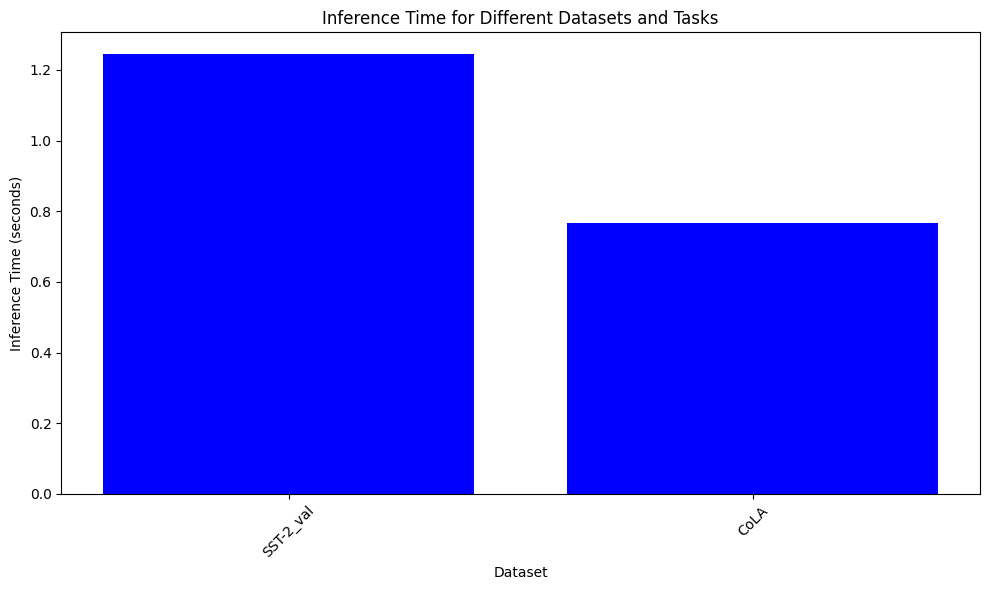

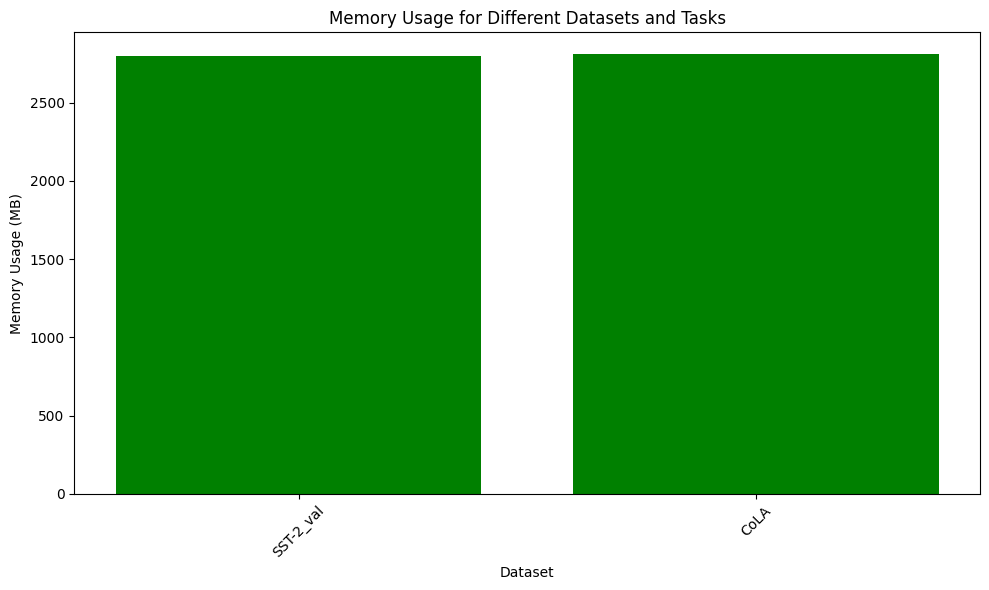

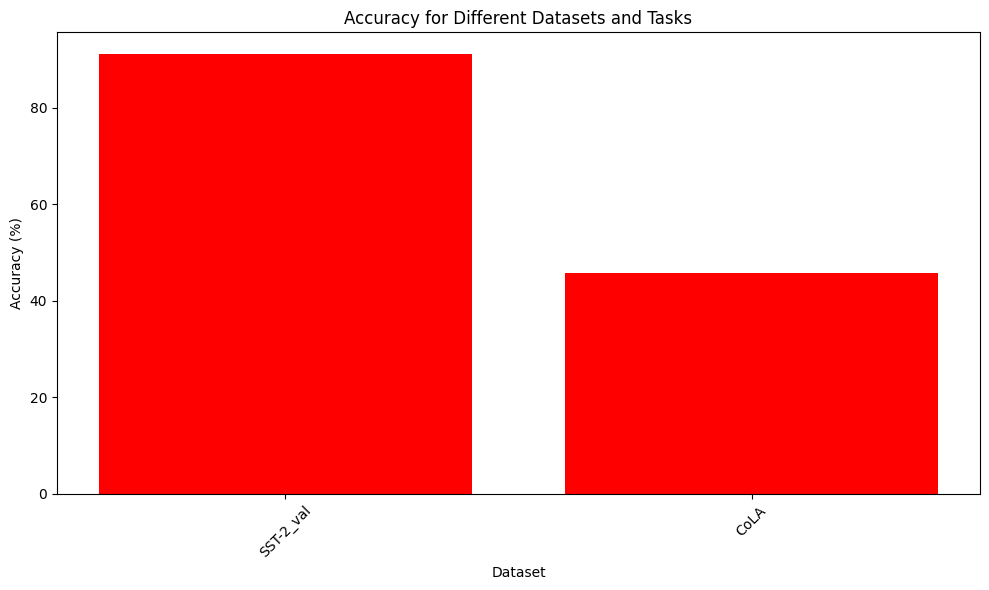

In [88]:
plt.figure(figsize=(10, 6))
plt.bar(data['Dataset'], data['Inference Time (seconds)'], color='blue')
plt.xlabel('Dataset')
plt.ylabel('Inference Time (seconds)')
plt.title('Inference Time for Different Datasets and Tasks')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('./result_image/inference_time.png', format='png')
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(data['Dataset'], data['Memory Usage (MB)'], color='green')
plt.xlabel('Dataset')
plt.ylabel('Memory Usage (MB)')
plt.title('Memory Usage for Different Datasets and Tasks')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('./result_image/memory_usage.png', format='png')
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(data['Dataset'], data['Accuracy (%)'], color='red')
plt.xlabel('Dataset')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy for Different Datasets and Tasks')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('./result_image/accuracy.png', format='png')
plt.show()


In [12]:
# model card of distilbert
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

model_path = '/home/yang1210/Files/LLM/models/distilbert-base-uncased-finetuned-sst-2-english'
tokenizer = DistilBertTokenizer.from_pretrained(model_path)
model = DistilBertForSequenceClassification.from_pretrained(model_path)

inputs = tokenizer("NO, my dog is ugly", return_tensors="pt")
with torch.no_grad():
    logits = model(**inputs).logits

predicted_class_id = logits.argmax().item()
print(predicted_class_id)
model.config.id2label[predicted_class_id]


0


'NEGATIVE'